## UCI DRUG REVIEW DATASET - SENTIMENT ANALYSIS USING KERAS

In [1]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style; style.use('ggplot')
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

## EDA

In [2]:
df = pd.read_csv("drugsComTrain_raw.csv") 

In [3]:
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 7 columns):
Unnamed: 0     161297 non-null int64
drugName       161297 non-null object
condition      160398 non-null object
review         161297 non-null object
rating         161297 non-null int64
date           161297 non-null object
usefulCount    161297 non-null int64
dtypes: int64(3), object(4)
memory usage: 8.6+ MB


In [6]:
list(df)

['Unnamed: 0',
 'drugName',
 'condition',
 'review',
 'rating',
 'date',
 'usefulCount']

In [7]:
conditions = df.condition.value_counts().sort_values(ascending=False)
conditions[:10]
#I stole this from a man and really liked it 

Birth Control      28788
Depression          9069
Pain                6145
Anxiety             5904
Acne                5588
Bipolar Disorde     4224
Insomnia            3673
Weight Loss         3609
Obesity             3568
ADHD                3383
Name: condition, dtype: int64

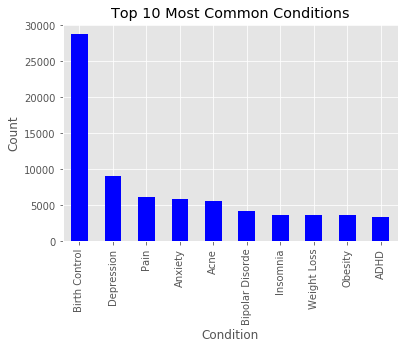

In [8]:
conditions[:10].plot(kind='bar', color='blue')
plt.title('Top 10 Most Common Conditions')
plt.xlabel('Condition')
plt.ylabel('Count');
#graph for this

In [9]:
df.rating.value_counts()

10    50989
9     27531
1     21619
8     18890
7      9456
5      8013
2      6931
3      6513
6      6343
4      5012
Name: rating, dtype: int64

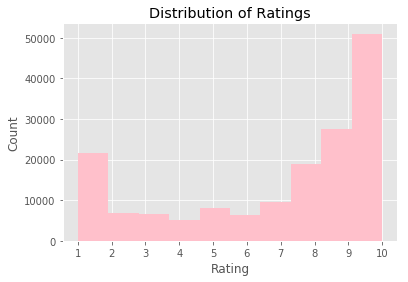

In [10]:
# Look at bias in review (also shown on 'Data' page in competition: distribution of ratings)
df.rating.hist(color='pink')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.xticks([i for i in range(1, 11)]);
#theres lots of 10's and 1's, people tend to go to extremes or to 5

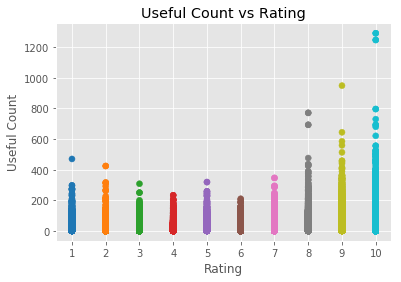

In [11]:
# Is rating correlated with usefulness of the review?
plt.scatter(df.rating, df.usefulCount, c=df.rating.values, cmap='tab10')
plt.title('Useful Count vs Rating')
plt.xlabel('Rating')
plt.ylabel('Useful Count')
plt.xticks([i for i in range(1, 11)]);

In [11]:
#this tels me that maybe it would be best to drop those three in the middle 

In [12]:
#check for nulls
df.isnull().sum()

Unnamed: 0       0
drugName         0
condition      899
review           0
rating           0
date             0
usefulCount      0
dtype: int64

In [28]:
#fill in 'Missing' for null values 
#reason: because theres a lot of them and those nulls are still valuable 
df['condition'].fillna('Missing', inplace = True)

In [14]:
df.isnull().sum()

Unnamed: 0     0
drugName       0
condition      0
review         0
rating         0
date           0
usefulCount    0
dtype: int64

In [29]:
#I want to drop the "Neutral" Values
df.drop(df[df.rating == 4].index, inplace=True)
df.drop(df[df.rating == 5].index, inplace=True)
df.drop(df[df.rating == 6].index, inplace=True)
df.drop(df[df.rating == 7].index, inplace=True)

In [30]:
#make new 'target' column where positive are rating 6-10, negative are rating 1-5
df['target'] = np.where(df['rating']>=8, 1, 0)

In [17]:
df.head(2)

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount,target
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,1
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,1


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132473 entries, 0 to 161296
Data columns (total 8 columns):
Unnamed: 0     132473 non-null int64
drugName       132473 non-null object
condition      132473 non-null object
review         132473 non-null object
rating         132473 non-null int64
date           132473 non-null object
usefulCount    132473 non-null int64
target         132473 non-null int64
dtypes: int64(4), object(4)
memory usage: 9.1+ MB


In [19]:
df.rating.value_counts()

10    50989
9     27531
1     21619
8     18890
2      6931
3      6513
Name: rating, dtype: int64

## Train Model

print(df[ df['target'] == 1].size)
print(df[ df['target'] == 0].size)


In [31]:
y = df.target
X = df.review

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [9]:
X_train,X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [22]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(92731,) (92731,)
(39742,) (39742,)


In [26]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
import keras

from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras import layers
from gensim.models import Word2Vec
from keras.preprocessing import sequence



## Cleanup data 

In [11]:
tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
                                   lower=True, split=' ', char_level=False, oov_token='OOV', document_count=0)

In [12]:
tokenizer.fit_on_texts(X_train)

In [13]:
tokenizer.texts_to_matrix(X_train)

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [30]:
np.array(list(zip(y_train, abs(1-y_train))))

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [0, 1],
       [1, 0],
       [1, 0]])

In [14]:
vectorizer = CountVectorizer(binary=True, stop_words=stopwords.words('english'),
                             lowercase=True, max_features=5000)

In [15]:
X_train = tokenizer.texts_to_matrix(X_train)
y_train = np.array(list(zip(y_train, abs(1-y_train))))
X_validation = tokenizer.texts_to_matrix(X_validation)
y_validation = np.array(list(zip(y_validation, abs(1-y_validation))))


In [16]:
print(X_train.shape)
print(y_train.shape)
print(X_validation.shape)
print(y_validation.shape)

(74184, 38851)
(74184, 2)
(18547, 38851)
(18547, 2)


In [22]:
model = Sequential()
model.add(Dense(units=256, activation='relu', input_dim=len(X_train[0])))
model.add(Dense(units=2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary

<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x1a360116d8>>

In [23]:
history = model.fit(X_train,y_train,epochs=3, batch_size=128, verbose=1,validation_data=(X_validation,y_validation))

W0801 10:32:44.035478 4554220992 deprecation.py:323] From /Users/req94983/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0801 10:32:44.074985 4554220992 deprecation_wrapper.py:119] From /Users/req94983/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 74184 samples, validate on 18547 samples
Epoch 1/3
74184/74184 [==============================] - 81s 1ms/step - loss: 0.3001 - acc: 0.8746 - val_loss: 0.2569 - val_acc: 0.8943
Epoch 2/3
74184/74184 [==============================] - 85s 1ms/step - loss: 0.1609 - acc: 0.9373 - val_loss: 0.2347 - val_acc: 0.9144
Epoch 3/3
74184/74184 [==============================] - 88s 1ms/step - loss: 0.0622 - acc: 0.9796 - val_loss: 0.2658 - val_acc: 0.9186


## Validation Set

In [44]:
X_train,X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [45]:
tokenizer = Tokenizer(num_words=None, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', 
                                   lower=True, split=' ', char_level=False, oov_token='OOV', document_count=0)

In [46]:
tokenizer.fit_on_texts(X_validation)

In [47]:
tokenizer.texts_to_matrix(X_validation)

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 0.]])

In [48]:
np.array(list(zip(y_validation, abs(1-y_validation))))

array([[1, 0],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]])

In [40]:
vectorizer = CountVectorizer(binary=True, stop_words=stopwords.words('english'),
                             lowercase=True, max_features=5000)

In [59]:
X_train = tokenizer.texts_to_matrix(X_train)
y_train = np.array(list(zip(y_train, abs(1-y_train))))
X_validation = tokenizer.texts_to_matrix(X_validation)
y_validation = np.array(list(zip(y_validation, abs(1-y_validation))))


In [61]:
print(X_train.shape)
print(y_train.shape)
print(X_validation.shape)
print(y_validation.shape)

(59347, 20122)
(59347, 2)
(14837, 20122)
(14837, 2)


## New Model

In [24]:
model = Sequential()
model.add(Dropout(.5))
model.add(Dense(units=256, activation='relu', input_dim=len(X_train[0])))
model.add(Dense(units=2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary

<bound method Network.summary of <keras.engine.sequential.Sequential object at 0x1a200c65c0>>

In [25]:
history = model.fit(X_train,y_train,epochs=3, batch_size=128, verbose=1,validation_data=(X_validation,y_validation))

W0801 10:41:26.690780 4554220992 deprecation.py:506] From /Users/req94983/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Train on 74184 samples, validate on 18547 samples
Epoch 1/3
74184/74184 [==============================] - 98s 1ms/step - loss: 0.4042 - acc: 0.8207 - val_loss: 0.3035 - val_acc: 0.8770
Epoch 2/3
74184/74184 [==============================] - 99s 1ms/step - loss: 0.3334 - acc: 0.8543 - val_loss: 0.2943 - val_acc: 0.8721
Epoch 3/3
74184/74184 [==============================] - 101s 1ms/step - loss: 0.2945 - acc: 0.8741 - val_loss: 0.2746 - val_acc: 0.8846
